In [2]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from joblib import Parallel, delayed
import seaborn as sns
import analysis_utils as au
import datetime
import pickle as pkl

import joblib 
import os

from joblib import dump, load

import time
import scipy.sparse

import scipy.stats

np_nonzero = np.nonzero
np_sum = np.sum
np_unique = np.unique


# gini computes


In [3]:
def local_bias(edges, user_map, true_prev, day, G_in, G_out, attn_func = None):
    in_deg = G_in
    out_deg = G_out
    if attn_func is None:
        attn_func = lambda edge: (1.0/in_deg(edge[1])) if in_deg(edge[1]) > 0 else 0.0
    num_edges = len(edges)
    exp_val = 0.0
    vals = map(lambda x: user_map[x[0]] * attn_func(x) / num_edges, edges)
    exp_val = np.nansum(list(vals))
    #for edge in edges:
    #    try:
    #        val = (user_map[edge[0]] * attn_func(edge)) * (1/num_edges)
    #    except KeyError as e:
    #        print(edge, out_deg, in_deg, list(edges))
    #        raise KeyError
    #    exp_val += val if not np.isnan(val) else 0.0
    '''
    for node in G.nodes():
        neighbors = G.neighbors(node)
        num_neighbors = len(neighbors)
        num_edges_neighbors = 0
        for neighbor in neighbors:
            num_edges_neighbors += G.degree(neighbor)
        local_bias = (num_edges_neighbors - num_neighbors) / (num_edges - num_neighbors)
        G.node[node]['local_bias'] = local_bias
    '''
    return np.mean(list(dict(in_deg).values())) * exp_val - true_prev



In [4]:
from numpy.random import default_rng

num_simulations = 50

rng = default_rng(42)
num_nodes = 5500
seed = 100
link_prob = 0.05
exponent=3.0






true_prevalence = 0.05

def gen_graph(num_nodes, exp):
    seq = [int(x) for x in nx.utils.powerlaw_sequence(num_nodes, exp)]
    G = nx.directed_configuration_model(seq, seq)
    G=nx.DiGraph(G)
    #G.remove_edges_from(G.selfloop_edges())
    return G

#G = nx.random_graphs.barabasi_albert_graph(n=num_nodes, m=1, seed=seed).to_directed()#
#G = nx.complete_graph(n=num_nodes).to_directed()#

#G = nx.erdos_renyi_graph(n=num_nodes, p=0.01).to_directed()

#G = nx.erdos_renyi_graph(n=num_nodes, p=link_prob, seed=seed, directed=True)
#G = nx.barabasi_albert_graph(n=num_nodes, m=5, seed=seed)

G = gen_graph(num_nodes, exponent)


vals = rng.binomial(n=1, p=true_prevalence, size=num_nodes)
user_map = {user:val for user, val in zip(list(range(num_nodes)), vals)}

lngths = [10, 100, 200]#list(np.arange(10,150,10))

start = 0.0
end = 0.75
corrs = np.arange(start, end, 0.15)

max_sesh_length = 200
num_days = 50
kinds = ['random', 'correlated', 'correlated-corrected', 'constant', 'popularity', 'friends-of-friends']#, 'rev-chronological']


rate = 10.  # average number of events per day
dt = .01  # time step
num_timesteps = int(1./dt) * num_days  # number of time steps



#starting_rho = nx.degree_assortativity_coefficient(G.to_directed(), x='in', y='in')
#
'''
tries = 0
while (nx.degree_assortativity_coefficient(G.to_directed(), x='in', y='in')) > -0.5 and not tries > 500:

    cur_asst = nx.degree_assortativity_coefficient(G.to_directed(), x='in', y='in')
    Gc = G.copy()
    nx.directed_edge_swap(Gc, nswap=50, max_tries=1e6)
    if nx.degree_assortativity_coefficient(Gc.to_directed(), x='in', y='in') < cur_asst:
        G = Gc
        tries = 0
    if tries % 50 == 0:
        print(tries, cur_asst)
    tries += 1
'''
#ending_rho = nx.degree_assortativity_coefficient(G.to_directed(), x='in', y='in')
#print("starting rho {} and ending_rho {}".format(starting_rho, ending_rho))




"\ntries = 0\nwhile (nx.degree_assortativity_coefficient(G.to_directed(), x='in', y='in')) > -0.5 and not tries > 500:\n\n    cur_asst = nx.degree_assortativity_coefficient(G.to_directed(), x='in', y='in')\n    Gc = G.copy()\n    nx.directed_edge_swap(Gc, nswap=50, max_tries=1e6)\n    if nx.degree_assortativity_coefficient(Gc.to_directed(), x='in', y='in') < cur_asst:\n        G = Gc\n        tries = 0\n    if tries % 50 == 0:\n        print(tries, cur_asst)\n    tries += 1\n"

In [5]:
np.mean(G.in_degree())

1375.5852727272727

In [6]:




def adjust_assort(G, goal_assort):
    tries = 0
    while (nx.degree_assortativity_coefficient(G, x='in', y='in')) > goal_assort and not tries > 500:

        cur_asst = nx.degree_assortativity_coefficient(G, x='in', y='in')
        Gc = G.copy()
        nx.directed_edge_swap(Gc, nswap=50, max_tries=1e6)
        if nx.degree_assortativity_coefficient(Gc, x='in', y='in') < cur_asst:
            G = Gc
            tries = 0
        if tries % 50 == 0:
            print(tries, cur_asst)
        tries += 1
    return G

def count_occurrences(choices, num_friends, user, mf):
    base = np.zeros((num_friends, num_days), dtype=np.int16)
    

    fn = map(np.unique, choices, [{'return_counts':True} for x in range(choices.shape[0])])
    
    #frs, cts = np.unique(choices, axis=0, return_counts=True)
    # print(frs, frs.shape, choices, choices.shape)
    for day, tup in zip(range(num_days), fn):
        frs = tup[0]
        cts = tup[1]
        #print(cts)
        if -1 in frs:     
            cts = cts[frs != -1]
            frs = frs[frs != -1]
        #frs, cts = np.unique(choices[:,day], return_counts=True)
        try:
            base[[mf[user].index(fr) if isinstance(mf, dict) else mf.index(fr) for fr in frs], day] = cts
        except ValueError:
            print(type(mf), "mf[user] ", mf[user], "user ", user, "frs ", frs )
            raise Exception
        except IndexError as e:
            print(day, type(mf), "mf[user] ", mf[user], "user ", user, "frs ", frs[day] )
            raise Exception
    return base

In [7]:
'''np.unique([1,3,5,6,7,7,7],\
           [2,2,2,3,4,4,5],\
           [3,4,5,5,6,2,5],\
           [4,5,2,3,3,4,4],\
           [0,0,0,0,1,2,1],\
           [1,2,1,3,4,2,3],\
           [7,7,6,5,4,3,7],\
           [0,0,0,0,1,2,1],\
           [1,1,1,2,2,1,2],\
           [1,2,3,4,1,2,3], axis=1, return_counts=True)'''

'np.unique([1,3,5,6,7,7,7],           [2,2,2,3,4,4,5],           [3,4,5,5,6,2,5],           [4,5,2,3,3,4,4],           [0,0,0,0,1,2,1],           [1,2,1,3,4,2,3],           [7,7,6,5,4,3,7],           [0,0,0,0,1,2,1],           [1,1,1,2,2,1,2],           [1,2,3,4,1,2,3], axis=1, return_counts=True)'

In [8]:
fn = lambda x: np.unique(return_counts=True)
for x in map(np.unique, [[1,7,7,7,3,5,6],\
           [2,2,2,3,4,4,5]], [{'return_counts':True}] * 2):
    print(x)

(array([1, 3, 5, 6, 7]), array([0, 4, 5, 6, 1]))
(array([2, 3, 4, 5]), array([0, 3, 4, 6]))


In [9]:
help(rng.poisson)

Help on built-in function poisson:

poisson(...) method of numpy.random._generator.Generator instance
    poisson(lam=1.0, size=None)
    
    Draw samples from a Poisson distribution.
    
    The Poisson distribution is the limit of the binomial distribution
    for large N.
    
    Parameters
    ----------
    lam : float or array_like of floats
        Expectation of interval, must be >= 0. A sequence of expectation
        intervals must be broadcastable over the requested size.
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  If size is ``None`` (default),
        a single value is returned if ``lam`` is a scalar. Otherwise,
        ``np.array(lam).size`` samples are drawn.
    
    Returns
    -------
    out : ndarray or scalar
        Drawn samples from the parameterized Poisson distribution.
    
    Notes
    -----
    The Poisson distribution
    
    .. math:: f(k; 

[ 6.  9.  3.  3.  7.  2.  6.  8.  4.  4.  1.  9.  7.  5.  5.  4.  6.  4.
  8.  7.  6.  7.  7.  3.  4.  1.  5.  4.  1.  3.  6.  3.  4.  6. 10.  1.
  7.  3.  4. 11.  7.  6.  7.  5.  4.  3.  3.  6.  7.  6.  7.  4.  4.  7.
  4.  4.  3.  4.  8.  4.  7.  5.  6.  4.  5.  2.  3.  5.  4.  6.  5.  2.
  5.  5.  6.  3.  5.  7.  6.  4.  1.  4.  5. 10.  2.  3.  2.  6.  4.  4.
 11.  7.  5.  5.  8.  3.  4.  8.  6.  7.]


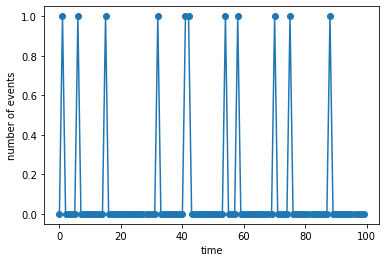

In [10]:
%matplotlib inline

#rng.poisson(lam=4.0, size=(5,num_days*48))
#rng.multivariate_hypergeometric(colors=[100]*50, nsample=10, size=3)

#generate a bunch of tweets
#each of these tweets are given a timestamp
#

rate = 10.  # average number of events per second
dt = .01  # time step
n = int(1./dt)  # number of time steps
x = np.zeros((50,n))
x[np.random.rand(50,n) <= rate*dt] = 1

print(sum(x))
#average number of events per day

# compute the number of events in each time bin
bins = np.arange(n+1)
y = np.histogram(np.where(x[0,:])[0], bins=bins)[0]

# plot the result
plt.plot(bins[:-1], y, 'o-')
plt.xlabel('time')
plt.ylabel('number of events')
plt.show()



In [11]:
def simulation(num_days, G):
    

    t0 = time.time()
    #G = nx.erdos_renyi_graph(n=num_nodes, p=link_prob, directed=True)
    
    G = gen_graph(num_nodes, exponent)

    #user_tweets = np.zeros((num_nodes,num_timesteps))
    #user_tweets[np.random.rand(num_nodes,num_timesteps) <= rate*dt] = 1



    #G = adjust_assort(G, -0.3)
    #G = G.to_directed()
    vals = rng.binomial(n=1, p=true_prevalence, size=num_nodes)
    user_map = {user:val for user, val in zip(list(range(num_nodes)), vals)}

    map_friends = list(G.edges())#who_follows_who[['id', 'tid']].groupby(['id', 'tid']).count().index.tolist()
    idx = pd.IndexSlice
    #map_friends = {tup[0]:[x[1] for x in map_friends if x[0] == tup[0]] for tup in map_friends}
    
    deg_cen = nx.degree_centrality(G)
    in_deg = G.in_degree()
    out_deg = G.out_degree()

    user_info = [(user, in_deg[user], out_deg[user], deg_cen[user]) for user in user_map]
    map_friends_2 = {}
    for tup in map_friends:
        try:
            map_friends_2[tup[0]].append(tup[1])
        except:
            map_friends_2[tup[0]] = [tup[1]]

    map_friends = map_friends_2
    map_friends_scores = {x:[user_map[y] for y in map_friends[x]] for x in map_friends}


    friends_dict = {x:{} for x in user_map}
    tot_frac_dict = {x:None for x in user_map}
    act_dfs_dict = {}

    t1 = time.time()
    t2 = t1
    print("Setup done -- time {}".format(t1 - t0))
    
    #for user in user_map:
    def job_user(user_chunk):
        tot_frac_dict = {}
        friends_dict = {}
        act_dfs_dict = {}
        for user in user_chunk:
            if user not in map_friends:
                continue
            t0 = t1
            friend_degrees = [out_deg[fr] for fr in map_friends[user]]
            #friends = {x:[] for x in map_friends[user]}#wfw_dict[user]
            #print("User {} has {} friends".format(user, len(friends)))
            
            ps = np.array([ deg / sum(friend_degrees) for deg in friend_degrees]) if sum(friend_degrees) > 0 else 1.0
            #ips = ps[np.argsort(ps)[::-1]]
            #user_choices = rng.multinomial([max_sesh_length]*num_days, pvals=ps)
            user_choices = rng.choice(np.array(map_friends[user]), size=(max_sesh_length, num_days), p=ps)
            
            act_dfs_correlated = [count_occurrences(user_choices[:x,:], len(map_friends[user]), user, map_friends) for x in lngths]
            
            ct_vals  = rng.integers(low=10,high=11, size=(len(map_friends[user]), num_days))
            act_dfs_constant =   [ct_vals for x in lngths]
            #[x for _, x in sorted(zip(Y, X), key=lambda pair: pair[0])]

            user_choices_pop =   rng.choice(map_friends[user], size=(max_sesh_length, num_days))
            degrees_in_choices = np.zeros((max_sesh_length, num_days))
            for day in range(num_days):
                degrees_in_choices[:, day] = [out_deg[x] for x in user_choices_pop[:,day]]
            # sorting the random activity by popularity
            #user_choices_pop= user_choices_pop[np.argsort(degrees_in_choices, axis=0)]
            #print(np.argsort(degrees_in_choices, axis=0).shape, user_choices_pop[np.argsort(degrees_in_choices, axis=0)].shape)
            sorted_degs = np.argsort(degrees_in_choices, axis=0)[::-1]
            act_dfs_popularity = [count_occurrences(user_choices_pop[sorted_degs][:x,:,0], len(map_friends[user]), user, map_friends) for x in lngths]

            #act_dfs_correlated_corrected = [act_df_corr[np.random.shuffle(np.arange(act_df_corr.shape[0])),:] for act_df_corr in act_dfs_correlated]
            #[rng.shuffle(act_df_corr, axis=0) for act_df_corr in [x.copy() for x in act_dfs_correlated]]
            
            act_dfs_correlated_corrected = [np.copy(x) for x in act_dfs_correlated]


    
            
            #for x in act_dfs_correlated_corrected:
            #    rng.shuffle(x, axis=0)

            # turning each act_df in act_dfs_correlated_corrected into a sparse matrix
            # act_dfs_correlated_corrected_sparse = [scipy.sparse.csr_matrix(x) for x in act_dfs_correlated_corrected]



            #user_choices_random = rng.choice(map_friends[user], size=(max_sesh_length, num_days))
            act_dfs_random = [count_occurrences(user_choices_pop[:x,:], len(map_friends[user]), user, map_friends) for x in lngths]

            fof = list(set(map_friends[user] + [y for x in [q for q in map_friends[user] if q in map_friends] for y in map_friends[x]]))
            #fof = list(set(fof))
            user_choices_fof = rng.choice(fof, size=(max_sesh_length, num_days))
            act_dfs_fof = [count_occurrences(user_choices_fof[:x,:], len(fof), user, fof) for x in lngths]


            # need to figure out how to do poisson tweets for every user
            #user_choices_rev_chron = rng.choice(np.array(map_friends[user]), size=(max_sesh_length, num_days), p=ps)

            #turn a matrix from (num_friends, num_timesteps) to (max_sesh_lengtrh, num_days)
            #user_choices_rev_chron = np.zeros((max_sesh_length, num_days), dtype=int) - np.ones((max_sesh_length, num_days), dtype=int)
            #num_ts = int(1/dt)
            '''
            for day in range(num_days):
                day_active = np.where(user_tweets[:,num_ts*day:num_ts*(day+1)] > 0)
                try:
                    users_active = np.array([x[0] for x in day_active if x[0] in map_friends[user]])
                except IndexError as e:
                    print(map_friends[user], day_active)
                user_choices_rev_chron[:len(users_active),day] = users_active[np.argsort([x[1] for x in day_active if x[0] in map_friends[user]])[::-1]][:max_sesh_length]
            
            where_active = np.where(user_tweets > 0)   # list of tuples (user, time)
            where_active_arr = np.array([[x[0], x[1]] for x in where_active if x[0] in map_friends[user]]) # array of (user, time)
            if where_active_arr.shape[0] > 0:
                
                sort_ix = np.argsort(where_active_arr[:,1])[::-1] # sort by time
                where_active_arr[:,1] = where_active_arr[:,1] / num_ts # convert time to day
                #tot_per_day = np.array([len(where_active_arr[where_active_arr[:,1] == day][:,0]) for day in range(num_days)]) # number of friends active on each day
                tot_per_day = map(lambda x: len(where_active_arr[where_active_arr[:,1] == x][:,0]), range(num_days))

                tot_ix = 0
                for tot in tot_per_day:
                    if tot == 0:
                        continue
                    user_choices_rev_chron[:tot, :] = where_active_arr[tot_ix:tot+tot_ix,0]
                    tot_ix += tot
            else:
                user_choices_rev_chron = np.zeros((max_sesh_length, num_days), dtype=int) - np.ones((max_sesh_length, num_days), dtype=int)
            #for day in range(num_days):
            #    day_ix = day*num_ts
            #    user_choices_rev_chron[:where_active_arr[where_active_arr[:,1] >= day_ix and where_active_arr[:,1] <= day_ix+num_ts ].shape[0], day] = 
            #users_active[np.argsort([x[1] for x in where_active if x[0] in map_friends[user]])[::-1]][:max_sesh_length]

            act_dfs_rev_chron = [count_occurrences(user_choices_rev_chron[:x,:], len(map_friends[user]), user, map_friends) for x in lngths]
            '''
            # sorting each act_df in act_dfs_correlated_corrected by time
            #act_dfs_rev_chron = [act_df[np.argsort(act_df[:,0], axis=0)[::-1],:] for act_df in act_dfs_correlated_corrected]

            '''
            additional types of sorting include:
            - by popularity
            - by degree centrality
            - by betweenness centrality
            - by closeness centrality
            - by eigenvector centrality
            - by clustering coefficient
            - by harmonic centrality
            - by pagerank
            - by katz centrality
            - by load centrality
            - by communicability centrality
            - by communicability betweenness centrality
            - by subgraph centrality
            - by subgraph betweenness centrality
            - by subgraph closeness centrality
            - by choosing friends in order'''


            #act_dfs_rev_chron
            friends = {x:[] for x in map_friends[user]}
            friends_scores = map_friends_scores[user]
            total_friend_pos_frac = sum(friends_scores) / float(len(friends)) if len(friends) > 0 else -1 
            tot_frac_dict[user] = {'whole': total_friend_pos_frac}
            friends_dict[user] = friends
            act_dfs_dict[user] = [act_dfs_random, act_dfs_correlated, \
                                  act_dfs_correlated_corrected, act_dfs_constant,\
                                  act_dfs_popularity, act_dfs_fof]#, act_dfs_rev_chron]
        #t1 = time.time()
        #print("done with user {} in {}".format(user, t1 - t0))
        #t0 = t1
        return act_dfs_dict, friends_dict, tot_frac_dict
    

    user_map_list = np.array_split(np.array(list(user_map.keys())), 9)
    results = Parallel(n_jobs=4)(delayed(job_user)(user_chunk) for user_chunk in user_map_list)
    
    tot_frac_dict = {}
    friends_dict = {}
    act_dfs_dict = {}
    for act_df_dict, friend_dict, tot_dict in results:
        act_dfs_dict.update(act_df_dict)
        friends_dict.update(friend_dict)
        tot_frac_dict.update(tot_dict)
   
    print("done with all users in {}".format(time.time() - t2))
    
    edge_dict = {kind:{} for kind in kinds}
    for kind in kinds:
        edge_dict[kind] = {length: [] for length in lngths}
        for user in [x for x in act_dfs_dict if x in map_friends]:
            
            for act_df, length in zip(act_dfs_dict[user][kinds.index(kind)], lngths):
                friends_seen = np.array([x > 0 for x in act_df.sum(axis=1)])
                edge_dict[kind][length].extend([(user, fr) for fr, seen in zip(map_friends[user], friends_seen) if seen == True])



    degrees = {node:deg for node,deg in G.in_degree()}
    degree_dist = [degrees[x] if x in degrees else 0 for x in user_map]
    assignments = [user_map[x] for x in user_map]

    avg_degree = np.mean(degree_dist)
    std_deg = np.std(degree_dist)

        
    def corr(x,y, um,):
        avg_pos_degree = np.mean([degrees[x] for x in um])
        #avg_degree = np.mean(x)
        #std_deg = np.std(x)
        std_vals = np.std(y)
        p_pos = np.sum(y) / float(len(y))

        return (p_pos / (std_deg * std_vals)) * np.abs(avg_pos_degree - avg_degree)

    def rewire_synth(goal_corr, assignments):
        cur_assignments = assignments
        cur_user_map = user_map
        list_user_map = list(user_map.keys())
        
        delta = 100000

        rev_user_map = {0:{x:0 for x in cur_user_map if cur_user_map[x] == 0}, 1:{x:0 for x in cur_user_map if cur_user_map[x] == 1}}
        pos_neg_bf = np.array([cur_user_map[x] for x in cur_user_map])
        posn_mapping = {user:ix for ix, user in enumerate(list_user_map)}
        rev_mapping = {ix: user for ix, user in enumerate(list_user_map)}

        positive_nodes = [rev_mapping[x] for x in np.nonzero(pos_neg_bf)[0]]#{x:0 for x in rev_user_map[1] if x in degrees}#set([node for node,assignment in zip(list_user_map, cur_assignments) if assignment == 1])
        negative_nodes = [rev_mapping[x] for x in np.nonzero(pos_neg_bf == 0)[0]]#{x:0 for x in rev_user_map[0] if x in degrees}#set([node for node,assignment in zip(list_user_map, cur_assignments) if assignment == 0])
        #cur_corr = corr(degree_dist, [*cur_user_map.values()], [*positive_nodes])
        cur_corr = corr(degree_dist, pos_neg_bf, positive_nodes)

        #print("done with ", goal_corr, " with corr ", cur_corr)
        iters = 0

        np_rand_choice = np.random.choice
        list_user_map_index = list_user_map.index
        while (cur_corr < goal_corr) and (iters < 10000):

            #es. For example, to increase ρkx, we randomly
            #choose nodes v1 with x = 1 and v0 with x = 0 and swap their attributes if the degree of v0 is
            #greater than the degree of v1. W
            
            #rand_pos = np_rand_choice(list([x for x in positive_nodes]), size=1)[0]
            rand_pos = np_rand_choice([rev_mapping[x] for x in np.nonzero(pos_neg_bf)[0]], size=min(100000, int(len(list_user_map)/100)), replace=False)

            rand_neg = np_rand_choice([rev_mapping[x] for x in np.nonzero(pos_neg_bf == 0)[0]], size=min(100000, int(len(list_user_map)/100)), replace=False)
            
            degrees_pos = [degree_dist[posn_mapping[x]] for x in rand_pos]
            degrees_neg = [degree_dist[posn_mapping[x]] for x in rand_neg]
            neg_gt_pos = [neg >= pos for neg, pos in zip(degrees_neg, degrees_pos)]
            if any(neg_gt_pos):
                true_tups = [ix for ix, val in enumerate(neg_gt_pos) if val]
                for tup_ix in true_tups:
                    pos = rand_pos[tup_ix]
                    neg = rand_neg[tup_ix]
                    cur_user_map[pos] = 0
                    cur_user_map[neg] = 1
                    pos_neg_bf[posn_mapping[pos]] = 0
                    pos_neg_bf[posn_mapping[neg]] = 1

                new_corr = corr(degree_dist, pos_neg_bf, [rev_mapping[x] for x in np.nonzero(pos_neg_bf)[0]])
                delta = new_corr - cur_corr
                cur_corr = new_corr

            iters += 1
            if iters % 5000 == 0:
                print(cur_corr, delta, iters)
        #return cur_assignments, cur_user_map, cur_corr
        return cur_user_map.values(), cur_user_map, cur_corr     

    corr_dict = {}
    map_friends_scores = {x:[user_map[y] for y in map_friends[x]] for x in map_friends}
    G_out = out_deg
    G_in = in_deg
    map_fof_deg = {user:sum([G_out[fr] for fr in map_friends[user]] + [G_out[y] for x in [q for q in map_friends[user] if q in map_friends] for y in map_friends[x]]) for user in map_friends}
    map_friend_deg = {user:sum([G_out[fr] for fr in map_friends[user]]) for user in map_friends}
    # map_deg_friends = {user: sum([degrees_out[fr] if fr in degrees_out else 0.0 for fr in map_friends[user]]) for user in map_friends}

    frac_dict = {}
    frac_tweets_dict = {}
    gini_dict = {}
    bias_dict = {}
    def job(user_chunk):
        #print("ENTERED USER ", user)
        
        
        for user in user_chunk:
            try:
                friends = {x:[] for x in map_friends[user]}#wfw_dict[user]
                friends_scores = map_friends_scores[user]
                fof = {x:[] for x in [y for y in map_friends[user]] + [q for y in [t for t in map_friends[user]  if t in map_friends] for q in map_friends[y]]}
            except Exception as e:
                print("no friends for user ", user)
                return (user, {}, {}, {}, {})#frac_dict, friends_dict, frac_tweets_dict
            #print(user)
            friends_list = np.array(list(friends.keys()))
            frac_dict[user] = {}
            frac_tweets_dict[user] = {}
            gini_dict[user] = {}
            bias_dict[user] = {}
            local_bias_vals = {}

        # max(1, map_deg_friends[edge[0]]))
            
            for act_dfs, kind in zip(act_dfs_dict[user], kinds):
            
                t0 = time.time()
                #print("local_bias_val ", local_bias_val)

                if kind == 'popularity' or kind=='correlated' or kind == 'correlated-corrected':
                    attn_func = lambda edge: (G_out[edge[0]]/max(1,map_friend_deg[edge[1]])) if map_friend_deg[edge[1]] > 0 else 0.0
                #elif kind == 'correlated':
                #    #attn_func = lambda edge: (G_out[edge[0]] / sum([G_out[fr] for fr in map_friends[edge[1]]])) if edge[1] in map_friends else 0.0 
                #    attn_func = lambda edge: (G_out[edge[0]] / map_friend_deg[edge[1]]) if edge[1] in map_friend_deg else 0.0
                elif kind == 'random' or kind == 'rev-chronological' :
                    attn_func = lambda edge: (1.0/G_in[edge[1]]) if G_in[edge[1]] > 0 else 0.0
                elif kind == 'friends-of-friends':
                    # TODO: precompute the sum of the out-degrees of the friends of friendsss
                    #attn_func = lambda edge: (1.0/sum([G_out[fr] for fr in map_friends[edge[1]]] + [G_out[y] for x in [q for q in map_friends[edge[1]] if q in map_friends] for y in map_friends[x]])) if edge[1] in map_friends else 0.0 
                    attn_func = lambda edge: (1.0/(map_fof_deg[edge[1]])) if edge[1] in map_fof_deg else 0.0
                #elif kind == 'correlated-corrected':
                #    #attn_func = lambda edge: (G_out[edge[0]] / sum([G_out[fr] for fr in map_friends[edge[1]]])) if edge[1] in map_friends else 0.0 
                #    attn_func  = lambda edge: (G_out[edge[0]] / map_friend_deg[edge[1]]) if edge[1] in map_friend_deg else 0.0
                elif kind == 'constant':
                    attn_func = lambda edge: (1.0/G_in[edge[1]])  if G_in[edge[1]] > 0 else 0.0   
                #print(kind)
                if kind == 'friends-of-friends':
                    friends = fof
                    friends_scores = [user_map[x] for x in friends]
                    friends_list = np.array(list(friends.keys()))
    


                total_friend_pos_frac = sum(friends_scores) / float(len(friends)) if len(friends) > 0 else -1 
                frac_dict[user][kind] = {'whole': total_friend_pos_frac}
                frac_tweets_dict[user][kind] = {}
                gini_dict[user][kind] = {}
                bias_dict[user][kind] = {}
                t1 = time.time()
                #logging.debug("Child {process.name} t1 before lengths {}".format(t1 - t0))
                t0 = t1
                
                for length, act_df, act_df_bin in zip(lngths, act_dfs, [act_df.copy() for act_df in act_dfs]):
                    days_list = [x for x in range(act_df.shape[1])]#x for x in gini_dict[user][length]]# if len(x) >0]
                    num_days = len(days_list)
                    str_len = str(length)
                    frac_dict[user][kind][str_len] = []
                    frac_tweets_dict[user][kind][str_len] = []
                    gini_dict[user][kind][str_len] = []
                    bias_dict[user][kind][str_len] = []

                    if kind == 'correlated-corrected':
                        index = np.arange(np.shape(act_df)[0])
                        rng.shuffle(index)
                        act_df = act_df[index,:]
                        act_df_bin = act_df_bin[index,:]

                    act_df_bin[act_df_bin != 0] = 1

                    friends_seen_total = np.asarray(np_nonzero(act_df_bin))


                    #friends_seen_subset = [x for x in friends_seen_total[0,:] if x in friends]#f
                    friends_seen_subset = np.unique(friends_seen_total[0,:])#[x in friends for x in friends_seen_total[0,:]]]
                    try:
                        friends_seen_sb_list = friends_list[friends_seen_subset]
                    except IndexError as e:
                        print(kind, str_len)
                        print(friends_list, friends_seen_subset)
                        raise Exception
                    fs_tr = [user_map[friend] for friend in friends_seen_sb_list]
                    where_fs_eq_1 = np_unique([friend for friend, tr in zip(friends_seen_subset, fs_tr) if tr == 1])

                    if len(where_fs_eq_1) == 0:
                        continue
                    #print(user, len(where_fs_eq_1), act_df_bin.shape)
                    #print(user, (np.sum(act_df_bin[where_fs_eq_1,:], axis=0) / (np.sum(act_df_bin, axis=0) +1.0)).flatten().tolist(), np.sum(act_df[where_fs_eq_1,:], axis=0) / (np.sum(act_df, axis=0) + 1.0).flatten().tolist() )
                    
                    #print(act_df_bin, where_fs_eq_1)
                    
                    
                    try:
                        sum_act_bin = np_sum(act_df_bin, axis=0)
                        where_zeros = np.where(sum_act_bin > 0)
                        small_ones = np.zeros(sum_act_bin.shape)
                        small_ones[where_zeros] = 1.0
                        sesh_friends_pos_frac = np_sum(act_df_bin[where_fs_eq_1,:], axis=0)[where_zeros] / (sum_act_bin[where_zeros])# + small_ones )   # array of length | number_days |
                        sesh_friend_tweets_pos_frac = np_sum(act_df[where_fs_eq_1,:], axis=0)[where_zeros] / (np_sum(act_df, axis=0)[where_zeros])# + small_ones)

                    except IndexError as e:
                        print(e)
                        print(len(where_fs_eq_1), act_df_bin.shape)
                        print(act_df_bin, where_fs_eq_1)
                        raise Exception
                    except RuntimeWarning as e:
                        #print('invalid divide by zero somewhere in act_df sum')
                        pass
                    gini_vals = np.array([au.compute_gini(act_df[:,day].astype('float64')) for day in range(act_df.shape[1])])
                    
                    local_bias_vals[kind] = local_bias(edge_dict[kind][length], user_map, true_prevalence, None, G_in, G_out, attn_func)

                    
                    #attn_func = lambda node, day: act_df[:,day].astype('float64') / np.sum(act_df[:,day]) num_times_seen/total_times if x == 0 else 1/x
                    #bias_vals = np.array([local_bias(G, user_map, true_prevalence, day, None) for day in range(act_df.shape[1])])
                    bias_vals = np.array([local_bias_vals[kind] for day in range(act_df.shape[1])])
                    #print(  act_df.shape, len(days_list), friends_seen_total.shape, fs_subset_tr.shape, sesh_friends_pos_frac.shape, np.mean(sesh_friends_pos_frac), )
                    frac_dict[user][kind][str_len].extend(sesh_friends_pos_frac.flatten().tolist())
                    frac_tweets_dict[user][kind][str_len].extend(sesh_friend_tweets_pos_frac.flatten().tolist())
                    gini_dict[user][kind][str_len].extend(gini_vals.flatten().tolist())
                    bias_dict[user][kind][str_len].extend(bias_vals.flatten().tolist())
                    t1 = time.time()
                    #print("USER {} done in ".format( user), t1 - t0, " length ", length, ' kind ', kind)
                
        return user_chunk, frac_dict, frac_tweets_dict, gini_dict, bias_dict
    
    for goal_corr in corrs:#[0, 0.25, 0.50, 0.75, 1.0]:

        t0 = time.time()
        assignments, user_map, cor = rewire_synth(goal_corr, assignments)
        t1 = time.time()
        print("done rewiring for {} in ".format(goal_corr), t1-t0)
        t0 = t1
        
        frac_dict_all = None
        frac_tweets_dict_all = None
        gini_dict_all = None
        bias_dict_all = None


        #def job(user, G, map_friends, map_friends_scores, kinds, user_map, G_out, G_in):
        '''
        for user in list(user_map.keys()):
            user, frac_dict, frac_tweets_dict, gini_dict, bias_dict = job(user, G, map_friends, map_friends_scores, kinds, user_map, G_out, G_in)
            if frac_dict_all is None:
                frac_dict_all = frac_dict
                frac_tweets_dict_all = frac_tweets_dict
                gini_dict_all = gini_dict
                bias_dict_all = bias_dict
            else:
                frac_dict_all.update(frac_dict)
                frac_tweets_dict_all.update(frac_tweets_dict)
                gini_dict_all.update(gini_dict)
                bias_dict_all.update(bias_dict)
        '''
        #chunk this out to multiple users at a time
        # chunk an array into n parts 


        user_map_list = np.array_split(np.array(list(user_map.keys())), 9)
        results = Parallel(n_jobs=4)(delayed(job)(user_chunk) for user_chunk in user_map_list)
        #frac_dict_all = frac_dict
        #frac_tweets_dict_all = frac_tweets_dict
        #gini_dict_all = gini_dict
        #bias_dict_all = bias_dict
        
        for user, frac_dict, frac_tweets_dict, gini_dict, bias_dict in results: 
            if frac_dict_all is None:
                frac_dict_all = frac_dict
                frac_tweets_dict_all = frac_tweets_dict
                gini_dict_all = gini_dict
                bias_dict_all = bias_dict
            else:
                frac_dict_all.update(frac_dict)
                frac_tweets_dict_all.update(frac_tweets_dict)
                gini_dict_all.update(gini_dict)
                bias_dict_all.update(bias_dict)
        
               
        t1 = time.time()
        print("time done whole job for corr {} in ".format(goal_corr), t1 - t0)
        t0  = t1
           
        corr_dict[goal_corr] = (frac_dict_all, frac_tweets_dict_all, gini_dict_all, bias_dict_all)

    fr_activity_tot = {}
    for kind in kinds:
        fr_activity = {}
        for user in act_dfs_dict:
            
            cur_act_df = act_dfs_dict[user][kinds.index(kind)][0][0] if kind == 'constant' else act_dfs_dict[user][kinds.index(kind)][-1]
            frs = map_friends[user]
            frs_ix = frs.index

            if kind != 'constant':
                if kind == 'correlated-corrected':
                        index = np.arange(np.shape(cur_act_df)[0])
                        rng.shuffle(index)
                        cur_act_df = cur_act_df[index,:]
                for fr in frs:
                    try:
                        fr_activity[fr].append(np.max(cur_act_df[frs_ix(fr),:]))
                    except KeyError as e:
                        try:
                            fr_activity[fr] = [np.max(cur_act_df[frs_ix(fr),:])]
                        except IndexError as e:
                            print("hi ", cur_act_df.shape, cur_act_df, frs_ix(fr))
                            raise Exception
            else:
                for fr in frs:
                    try:
                        fr_activity[fr].append(np.max(cur_act_df[frs_ix(fr)]))
                    except KeyError as e:
                        #print(cur_act_df, frs_ix(fr))
                        try:
                            fr_activity[fr] = [np.max(cur_act_df[frs_ix(fr)])]
                        except IndexError as e:
                            print(e, fr, kind)
                            continue
                    except IndexError as e:
                        print('IndexError ', e, fr, kind)
                        continue
        fr_activity_tot[kind] = (fr_activity, [G.in_degree()[x] for x in fr_activity])
    
    return fr_activity_tot, corr_dict, user_info




In [12]:
'''
G = gen_graph(num_nodes, exponent)

user_tweets = np.zeros((num_nodes,num_timesteps))
user_tweets[np.random.rand(num_nodes,num_timesteps) <= rate*dt] = 1



#G = adjust_assort(G, -0.3)
#G = G.to_directed()
vals = rng.binomial(n=1, p=true_prevalence, size=num_nodes)
user_map = {user:val for user, val in zip(list(range(num_nodes)), vals)}

map_friends = list(G.edges())#who_follows_who[['id', 'tid']].groupby(['id', 'tid']).count().index.tolist()
idx = pd.IndexSlice
#map_friends = {tup[0]:[x[1] for x in map_friends if x[0] == tup[0]] for tup in map_friends}

deg_cen = nx.degree_centrality(G)
in_deg = G.in_degree()
out_deg = G.out_degree()

user_info = [(user, in_deg[user], out_deg[user], deg_cen[user]) for user in user_map]
map_friends_2 = {}
for tup in map_friends:
    try:
        map_friends_2[tup[0]].append(tup[1])
    except:
        map_friends_2[tup[0]] = [tup[1]]

map_friends = map_friends_2
map_friends_scores = {x:[user_map[y] for y in map_friends[x]] for x in map_friends}



user_choices_rev_chron = np.zeros((max_sesh_length, num_days), dtype=int) - np.ones((max_sesh_length, num_days), dtype=int)
num_ts = int(1/dt)

where_active = np.where(user_tweets > 0)   # list of tuples (user, time)
where_active_arr = np.array([[x[0], x[1]] for x in where_active if x[0] in map_friends[user]]) # array of (user, time)
if where_active_arr.shape[0] > 0:
    
    sort_ix = np.argsort(where_active_arr[:,1])[::-1] # sort by time
    where_active_arr[:,1] = where_active_arr[:,1] / num_ts # convert time to day
    #tot_per_day = np.array([len(where_active_arr[where_active_arr[:,1] == day][:,0]) for day in range(num_days)]) # number of friends active on each day
    tot_per_day = map(lambda x: len(where_active_arr[where_active_arr[:,1] == x][:,0]), range(num_days))

    tot_ix = 0
    for tot in tot_per_day:
        if tot == 0:
            continue
        user_choices_rev_chron[:tot, :] = where_active_arr[tot_ix:tot+tot_ix,0]
        tot_ix += tot
else:
    user_choices_rev_chron = np.zeros((max_sesh_length, num_days), dtype=int) - np.ones((max_sesh_length, num_days), dtype=int)
'''

"\nG = gen_graph(num_nodes, exponent)\n\nuser_tweets = np.zeros((num_nodes,num_timesteps))\nuser_tweets[np.random.rand(num_nodes,num_timesteps) <= rate*dt] = 1\n\n\n\n#G = adjust_assort(G, -0.3)\n#G = G.to_directed()\nvals = rng.binomial(n=1, p=true_prevalence, size=num_nodes)\nuser_map = {user:val for user, val in zip(list(range(num_nodes)), vals)}\n\nmap_friends = list(G.edges())#who_follows_who[['id', 'tid']].groupby(['id', 'tid']).count().index.tolist()\nidx = pd.IndexSlice\n#map_friends = {tup[0]:[x[1] for x in map_friends if x[0] == tup[0]] for tup in map_friends}\n\ndeg_cen = nx.degree_centrality(G)\nin_deg = G.in_degree()\nout_deg = G.out_degree()\n\nuser_info = [(user, in_deg[user], out_deg[user], deg_cen[user]) for user in user_map]\nmap_friends_2 = {}\nfor tup in map_friends:\n    try:\n        map_friends_2[tup[0]].append(tup[1])\n    except:\n        map_friends_2[tup[0]] = [tup[1]]\n\nmap_friends = map_friends_2\nmap_friends_scores = {x:[user_map[y] for y in map_friends[x

In [13]:

total_cur_corr_vals = {kind:[] for kind in kinds}
multi_sim_fr_activitys = {kind: [] for kind in kinds}
for sim_ix in np.arange(num_simulations):
    print("simulation ", sim_ix)

    fr_activity_tot, corr_dict, user_info = simulation(num_days, G.copy())



    offset = 0.00
    users = [x[0] for x in sorted(user_info, key=lambda y: y[3])[::-1]][:]#[user for user in user_map]
    
    # 1 for users 3 for tweets
    for kind in kinds:
        fr_act_vs_deg = fr_activity_tot[kind]
        multi_sim_fr_activitys[kind].append(fr_act_vs_deg)
        cur_corr_vals = []
        for length in lngths:
            #print(length)
            
            for cor in corrs:#, 0.75, 1.0]:
                #print("corr {}".format(cor))
                frac_tweets_dict = corr_dict[cor]
                

                nums = []
                ginis = []
                user_nums = []
                biases = []
                for user in users: # filter on users
                    try:
                        if len([x[user] if user in x else [] for x in frac_tweets_dict]) == 0:
                            continue
                    except KeyError as e:
                        print (frac_tweets_dict)
                        raise Exception
                    try:
                        user_tweet_frac = frac_tweets_dict[1][user][kind]
                        user_gini = frac_tweets_dict[2][user][kind]
                        user_frac = frac_tweets_dict[0][user][kind]
                        user_bias = frac_tweets_dict[3][user][kind]
                    except KeyError as e:
                        continue
                    #below for user friends frac tweets per day
                    #length_fracs = [x if x == 0.0 else x.data[0] for x in user_gini[0][str(length)]]
                    length_fracs = [x for x in user_tweet_frac[str(length)]]
                    length_ginis = [x for x in user_gini[str(length)]]
                    length_user_fracs = [x for x in user_frac[str(length)]]
                    length_user_bias = [x for x in user_bias[str(length)]]


                    if all([np.isnan(x) for x in length_fracs]):
                        continue
                    #print(length_fracs)
                    if isinstance(length_fracs, np.float64):
                        if not np.isnan(length_fracs) and x >= 0.0:
                            nums.append(length_fracs)
                            ginis.append(length_ginis)
                            user_nums.append(length_user_fracs)
                            biases.append(length_user_bias)
                    else:
                        nums.extend([x for x in length_fracs if not np.isnan(x) and x >= 0.0])
                        ginis.extend([x for x in length_ginis if not np.isnan(x) and x >= 0.0])
                        user_nums.extend([x for x in length_user_fracs if not np.isnan(x) and x >= 0.0])
                        biases.extend([x for x in length_user_bias if not np.isnan(x) and x >= 0.0])

                    #nums.extend([x for x  in length_fracs[0] if len(length_fracs[0]) > s1 else ])
                #print(nums)

                cur_corr_vals.append((np.nanmean(nums), scipy.stats.sem(nums), np.nanmean(ginis), np.nanmean(user_nums), np.nanmean(biases)))
                #print(scipy.stats.sem(nums))
            total_cur_corr_vals[kind].append(cur_corr_vals)
            
            #print([tup[1] for tup in cur_corr_vals])



simulation  0
Setup done -- time 0.15922307968139648
done with all users in 32.94785714149475
done rewiring for 0.0 in  0.005381107330322266
time done whole job for corr 0.0 in  91.3980348110199
done rewiring for 0.15 in  0.03129005432128906
time done whole job for corr 0.15 in  103.57990884780884
done rewiring for 0.3 in  0.0612490177154541
time done whole job for corr 0.3 in  117.95094180107117
done rewiring for 0.44999999999999996 in  0.09661483764648438
time done whole job for corr 0.44999999999999996 in  123.1511971950531
done rewiring for 0.6 in  0.3601670265197754
time done whole job for corr 0.6 in  123.54874801635742
IndexError  index 50 is out of bounds for axis 0 with size 50 5095 constant
IndexError  index 51 is out of bounds for axis 0 with size 50 1293 constant
IndexError  index 52 is out of bounds for axis 0 with size 50 1923 constant
IndexError  index 53 is out of bounds for axis 0 with size 50 3275 constant
index 54 is out of bounds for axis 0 with size 50 3825 constan

/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_88008/2330450440.py:70: RuntimeWarning: Mean of empty slice
  cur_corr_vals.append((np.nanmean(nums), scipy.stats.sem(nums), np.nanmean(ginis), np.nanmean(user_nums), np.nanmean(biases)))


simulation  1
Setup done -- time 0.11255383491516113
done with all users in 25.915539979934692
done rewiring for 0.0 in  0.00423884391784668
time done whole job for corr 0.0 in  62.96127200126648
done rewiring for 0.15 in  0.05214381217956543
time done whole job for corr 0.15 in  90.88587021827698
done rewiring for 0.3 in  0.06973004341125488


In [ ]:
total_cur_corr_vals

{'random': [[(0.34243051327524904,
    0.009050791218797946,
    0.10122098923813365,
    0.34183471664073417,
    nan),
   (0.36493600139860116,
    0.006581954448865123,
    0.10076794612483102,
    0.3656776324543359,
    0.11359318551121333),
   (0.4005269544028347,
    0.005818865942283963,
    0.10044191248192152,
    0.40164698629339934,
    0.21606806796262465),
   (0.42784479318824464,
    0.005228321089640509,
    0.10013532544671237,
    0.4288818356502171,
    0.30262357077697316),
   (0.4520315217008803,
    0.004858553915361188,
    0.10004553277214909,
    0.4523033086791405,
    0.38723855824208725),
   (0.34381396444800166,
    0.004039354727473745,
    0.49514886716486756,
    0.34161309888639474,
    nan),
   (0.3679804784550612,
    0.0029391343572003556,
    0.4948218632641097,
    0.3669218416313475,
    0.11355828935389443),
   (0.4037048960445146,
    0.002594418588829833,
    0.49449094110947434,
    0.40337655709281117,
    0.21601131282867356),
   (0.42743651

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


random
hi
correlated
hi
correlated-corrected
hi
constant
hi
popularity
hi
friends-of-friends
hi


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/2677812677.py:36: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(lngth_arr, axis=0)
/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/2677812677.py:36: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(lngth_arr, axis=0)
/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/2677812677.py:36: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(lngth_arr, axis=0)


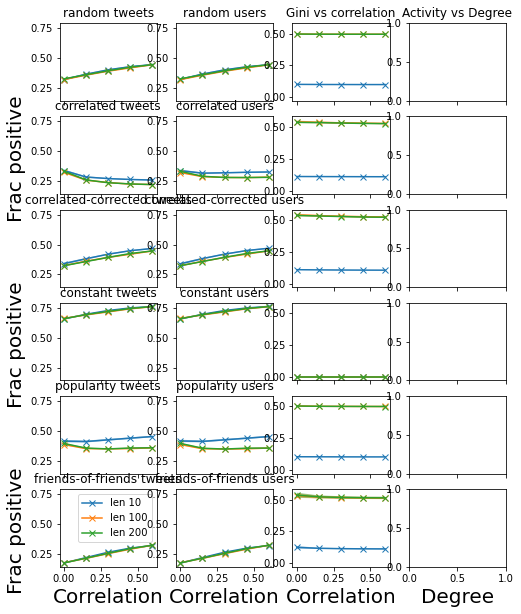

In [ ]:
%matplotlib inline
fig, axarr = plt.subplots(len(kinds),4, figsize=(8,10), sharey='col', sharex='col')
# for each length then make a boxplot for each user at that session length
posn = 0
colors = ['r', 'g', 'b', 'c']
cix = 0
boxes = []
plt.rcParams["figure.autolayout"] = True


for kind in kinds:
    print(kind)
    try:
        arr = np.array(total_cur_corr_vals[kind])
        #fr_act_vs_deg = fr_activity_tot[kind]#
        fr_act_vs_deg = multi_sim_fr_activitys[kind]

    except KeyError as e:
        if kind == 'friends-of-friends':
            arr = np.array(total_cur_corr_vals['fof'])#np.array([x[0] for x in total_cur_corr_vals['fof'][0]])
            fr_act_vs_deg = [x[1] for x in total_cur_corr_vals['fof']][0]
            #arr = np.array(total_cur_corr_vals['fof'][0])
            #fr_act_vs_deg = fr_activity_tot['fof'][1][0]
            
    


    for length in lngths:
        sim_ix =  lngths.index(length) * num_simulations
        min_ix = lngths.index(length) * 5
        lngth_arr = arr[sim_ix:sim_ix+num_simulations,:,:]

        ind = np.unravel_index(np.argsort(lngth_arr, axis=0), arr.shape)
        ind = np.argsort(lngth_arr[:,-1,0], axis=0)

        mns = np.nanmean(lngth_arr, axis=0)
        stdevs = np.std(lngth_arr, axis=0)

        '''
        print(ind.shape, lngth_arr.shape, sim_ix, min_ix, lngth_arr[ind,:].shape)
        print(lngth_arr[ind,:])
        print('hi')
        print(lngth_arr[ind,:][0,0,min_ix:min_ix+2,0])
        raise Exception
        '''

        
        # tweet frac
        axarr[posn][0].fill_between(x=[x for x in corrs],\
                                    y1=mns[min_ix:min_ix+5,0] - mns[min_ix:min_ix+5,1],\
                                    y2=mns[min_ix:min_ix+5,0] + mns[min_ix:min_ix+5,1], alpha=0.45)
        
        axarr[posn][0].plot([x for x in corrs], mns[min_ix:min_ix+5, 0], marker='x', label=('len {}'.format(length)))

        # user frac
        axarr[posn][1].fill_between(x=[x for x in corrs],\
                                    y1=mns[min_ix:min_ix+5,3] - mns[min_ix:min_ix+5,1],\
                                    y2=mns[min_ix:min_ix+5,3] + mns[min_ix:min_ix+5,1], alpha=0.45)
        
        axarr[posn][1].plot([x for x in corrs], mns[min_ix:min_ix+5, 3], marker='x', label=('len {}'.format(length)))

        # gini based on tweets
        axarr[posn][2].fill_between(x=[x for x in corrs],\
                                    y1=mns[min_ix:min_ix+5,2] - stdevs[min_ix:min_ix+5,2],\
                                    y2=mns[min_ix:min_ix+5,2] + stdevs[min_ix:min_ix+5,2], alpha=0.45)
        
        axarr[posn][2].plot([x for x in corrs], mns[min_ix:min_ix+5, 2], marker='x', label=('len {}'.format(length)))
        '''
        
        axarr[posn][0].fill_between(x=[x for x in corrs],\
                                    y1=lngth_arr[ind][-2,min_ix:min_ix+5,0],\
                                    y2=lngth_arr[ind][2,min_ix:min_ix+5,0], alpha=0.45)

        axarr[posn][0].plot( [x for x in corrs], lngth_arr[ind][int(num_simulations/2),min_ix:min_ix+5,0], marker='x', label='len {}'.format(length))

        axarr[posn][1].fill_between(x=[x for x in corrs],\
                                    y1=lngth_arr[ind][-2,min_ix:min_ix+5,3],\
                                    y2=lngth_arr[ind][2,min_ix:min_ix+5,3], alpha=0.45)

        axarr[posn][1].plot( [x for x in corrs], lngth_arr[ind][int(num_simulations/2),min_ix:min_ix+5,3], marker='x', label='len {}'.format(length))

        #ind = np.argsort(lngth_arr[:,-1,2])
        axarr[posn][2].fill_between(x=[x for x in corrs],\
                                    y1=lngth_arr[ind][-2,min_ix:min_ix+5,2],\
                                    y2=lngth_arr[ind][2,min_ix:min_ix+5,2], alpha=0.45)
        axarr[posn][2].plot( [ x for x in corrs], lngth_arr[ind][int(num_simulations/2),min_ix:min_ix+5,2], marker='x', label='len {}'.format(length))
        '''

    #print(boxes)
    axarr[posn][0].set_title('{} tweets'.format(kind))
    axarr[posn][1].set_title('{} users'.format(kind))

    if posn % 2: axarr[posn][0].set_ylabel('Frac positive ', fontsize=20)
    #if posn % 2: axarr[posn][2].set_ylabel('Gini coefficient', fontsize=20)
    try:
        #intersection_friends = list(  set([fr for fr_act_vs_deg_tup in [x[0] for x in [multi_sim_fr_activitys[kind][0][0]]] for fr in fr_act_vs_deg_tup]) .union(\
        #                              set([fr for fr_act_vs_deg_tup in [x[0] for x in multi_sim_fr_activitys[kind]] for fr in fr_act_vs_deg_tup]) ))
        
        #intersection_degs = [ np.median([x[1][list(x[0].keys()).index(fr)] for x in multi_sim_fr_activitys[kind]])   for fr in intersection_friends ]

        #intersection_acts = [ np.median([np.median(x[0][fr]) for x in multi_sim_fr_activitys[kind]])  for fr in intersection_friends]
        #axarr[posn][3].scatter(intersection_degs, intersection_acts)
        #corr_val, p_val = scipy.stats.pearsonr(intersection_degs, intersection_acts )
        
        #axarr[posn][3].scatter(fr_act_vs_deg[1], [np.median(fr_act_vs_deg[0][fr]) for fr in fr_act_vs_deg[0]])
        #corr_val, p_val = scipy.stats.pearsonr(fr_act_vs_deg[1], [np.median(fr_act_vs_deg[0][fr]) for fr in fr_act_vs_deg[0]] )
        
        print('hi')

        #axarr[posn][3].annotate('corr: {0:.2f}'.format(corr_val), \
        #                        xy=(0.45,0.87), xycoords = 'axes fraction', \
        #                        xytext=(0.45,.87),textcoords='axes fraction')
    except TypeError as e:
        print(kind, [x[0] for x in [multi_sim_fr_activitys[kind][0][0]]])
        raise Exception
    if posn == 0: axarr[posn][3].set_title('Activity vs Degree')
    if posn == 0: axarr[posn][2].set_title('Gini vs correlation')
    
    posn+=1
    axarr[len(kinds)-1][0].set_xlabel('Correlation', fontsize=20)
    axarr[len(kinds)-1][3].set_xlabel('Degree', fontsize=20)
    axarr[len(kinds)-1][0].legend()
    axarr[len(kinds)-1][1].set_xlabel('Correlation', fontsize=20)
    axarr[len(kinds)-1][2].set_xlabel('Correlation', fontsize=20)
        #posn+=0.4
        ##for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            #plt.setp(bp[item], color=colors[cix])
        #cix+=1

/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/4165827321.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]


hi


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/4165827321.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]


hi


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/4165827321.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]


hi


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/4165827321.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]
/Users/Bartley/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


hi


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/4165827321.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]


hi


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/4165827321.py:72: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]


hi


/Users/Bartley/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


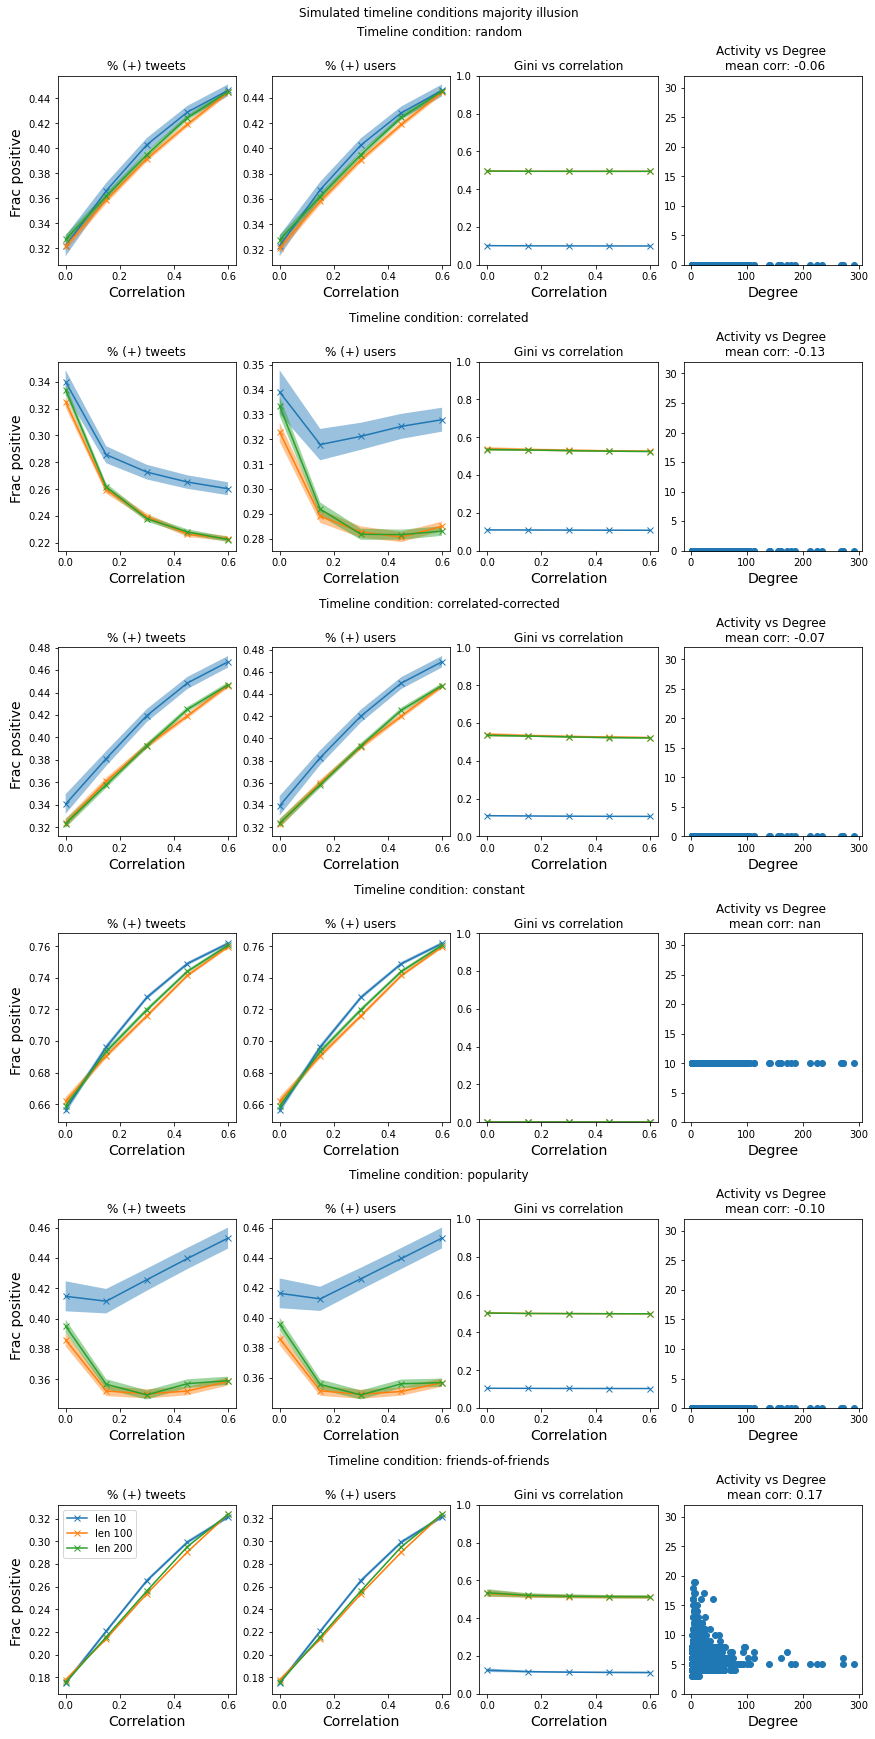

In [ ]:
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize=(12,24))
fig.suptitle('Simulated timeline conditions majority illusion')

posn = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(kinds), ncols=1)
for row, subfig in enumerate(subfigs):
    kind = kinds[row]
    subfig.suptitle(f'Timeline condition: {kind}')

    try:
        arr = np.array(total_cur_corr_vals[kind])
        #fr_act_vs_deg = fr_activity_tot[kind]#
        fr_act_vs_deg = multi_sim_fr_activitys[kind]

    except KeyError as e:
        if kind == 'friends-of-friends':
            arr = np.array(total_cur_corr_vals['fof'])#np.array([x[0] for x in total_cur_corr_vals['fof'][0]])
            fr_act_vs_deg = multi_sim_fr_activitys['fof']
            #arr = np.array(total_cur_corr_vals['fof'][0])
            #fr_act_vs_deg = fr_activity_tot['fof'][1][0]
                
        

    axarr = subfig.subplots(nrows=1, ncols=4, sharey='col', sharex='col') 
    for length in lngths:
        sim_ix =  lngths.index(length) * num_simulations
        min_ix = lngths.index(length) * 5
        lngth_arr = arr[sim_ix:sim_ix+num_simulations,:,:]

        ind = np.unravel_index(np.argsort(lngth_arr, axis=0), arr.shape)
        ind = np.argsort(lngth_arr[:,-1,0], axis=0)

        mns = np.mean(lngth_arr, axis=0)
        stdevs = np.std(lngth_arr, axis=0)
         # tweet frac
        axarr[0].fill_between(x=[x for x in corrs],\
                                    y1=mns[min_ix:min_ix+5,0] - mns[min_ix:min_ix+5,1],\
                                    y2=mns[min_ix:min_ix+5,0] + mns[min_ix:min_ix+5,1], alpha=0.45)
        
        axarr[0].plot([x for x in corrs], mns[min_ix:min_ix+5, 0], marker='x', label=('len {}'.format(length)))

        # user frac
        axarr[1].fill_between(x=[x for x in corrs],\
                                    y1=mns[min_ix:min_ix+5,3] - mns[min_ix:min_ix+5,1],\
                                    y2=mns[min_ix:min_ix+5,3] + mns[min_ix:min_ix+5,1], alpha=0.45)
        
        axarr[1].plot([x for x in corrs], mns[min_ix:min_ix+5, 3], marker='x', label=('len {}'.format(length)))

        # gini based on tweets
        axarr[2].fill_between(x=[x for x in corrs],\
                                    y1=mns[min_ix:min_ix+5,2] - stdevs[min_ix:min_ix+5,2],\
                                    y2=mns[min_ix:min_ix+5,2] + stdevs[min_ix:min_ix+5,2], alpha=0.45)
        
        axarr[2].plot([x for x in corrs], mns[min_ix:min_ix+5, 2], marker='x', label=('len {}'.format(length)))


    axarr[0].set_title('% (+) tweets'.format(kind))
    axarr[1].set_title('% (+) users'.format(kind))

    axarr[0].set_ylabel('Frac positive ', fontsize=14)
    #if posn % 2: axarr[posn][2].set_ylabel('Gini coefficient', fontsize=20)
    try:
       
        intersection_friends = list(  set([fr for fr_act_vs_deg_tup in [x[0] for x in [multi_sim_fr_activitys[kind][0][0]]] for fr in fr_act_vs_deg_tup]) .union(\
                                      set([fr for fr_act_vs_deg_tup in [x[0] for x in multi_sim_fr_activitys[kind]] for fr in fr_act_vs_deg_tup]) ))
        
        intersection_degs = [ np.max([x[1][list(x[0].keys()).index(fr)] if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])   for fr in intersection_friends ]

        intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]
        #print(intersection_acts)
        #print("hi degs ", intersection_degs)
        axarr[3].scatter(intersection_degs, intersection_acts)
        #corr_val, p_val = scipy.stats.pearsonr(intersection_degs, intersection_acts )

        # get the mean correlation out of all the the slices
        #corr_val, p_val = scipy.stats.pearsonr(intersection_degs, intersection_acts )
        corr_val_list = [scipy.stats.pearsonr(tup[1], [np.median(tup[0][fr]) for fr in tup[0]])[0] for tup in multi_sim_fr_activitys[kind]]
        


        corr_val = np.mean(corr_val_list)
        
        print('hi')
        #axarr[3].scatter(fr_act_vs_deg[1], [np.median(fr_act_vs_deg[0][fr]) for fr in fr_act_vs_deg[0]])
        #corr_val, p_val = scipy.stats.pearsonr(fr_act_vs_deg[1], [np.median(fr_act_vs_deg[0][fr]) for fr in fr_act_vs_deg[0]] )
        

        
        #axarr[3].annotate('corr: {0:.2f}'.format(corr_val), \
        #                        xy=(0.65,1.05), xycoords = 'axes fraction', \
        #                        xytext=(0.65,1.05),textcoords='axes fraction')
    except TypeError as e:
        print(kind, [x[0] for x in [multi_sim_fr_activitys[kind][0][0]]])
        raise Exception
    except IndexError as e:
         for fr in intersection_friends:
            print(fr)
            #print(multi_sim_fr_activitys[kind])
            print([scipy.stats.mode(x[0][fr]) for x in multi_sim_fr_activitys[kind]])
            raise Exception

    axarr[3].set_title('Activity vs Degree \n mean corr: {0:.2f}'.format(corr_val))
    axarr[2].set_title('Gini vs correlation')
    
    posn+=1
    axarr[0].set_xlabel('Correlation', fontsize=14)
    axarr[3].set_xlabel('Degree', fontsize=14)
    if posn == 6: axarr[0].legend()
    axarr[1].set_xlabel('Correlation', fontsize=14)
    axarr[2].set_xlabel('Correlation', fontsize=14)
    #axarr[0].set_ylim([0.0,1.])
    #axarr[1].set_ylim([0.0,1.])
    axarr[2].set_ylim([0.0, 1.0])
    axarr[3].set_ylim([0,32])
    #axarr[3].set_xlim([0, 12])
    # create 1x3 subplots per subfig
    
    #for col, ax in enumerate(axs):
    #    ax.plot()
    #    ax.set_title(f'Plot title {col}')

In [ ]:
%matplotlib inline 




In [ ]:
print("in out ", nx.degree_assortativity_coefficient(G, x="in", y="out"))
print("in in ", nx.degree_assortativity_coefficient(G, x="in", y="in"))
print("out out ", nx.degree_assortativity_coefficient(G, x="out", y="out"))
print("out in ", nx.degree_assortativity_coefficient(G, x="in", y="in"))

in out  0.0012438871754525886
in in  0.0011627324436318607
out out  0.0012075400992295367
out in  0.0011627324436318607


In [ ]:
corr_dict[0.6][1]

{4889: {'random': {'10': [], '100': [], '200': []},
  'correlated': {'10': [], '100': [], '200': []},
  'correlated-corrected': {'10': [], '100': [], '200': []},
  'constant': {'10': [], '100': [], '200': []},
  'popularity': {'10': [], '100': [], '200': []},
  'friends-of-friends': {'10': [0.6666666666666666,
    0.8,
    0.3333333333333333,
    0.14285714285714285,
    0.6666666666666666,
    0.2,
    0.0,
    0.0,
    0.125,
    0.3333333333333333],
   '100': [0.6666666666666666,
    0.8,
    0.3333333333333333,
    0.14285714285714285,
    0.6666666666666666,
    0.2,
    0.0,
    0.0,
    0.125,
    0.3333333333333333,
    0.3,
    0.2,
    0.2857142857142857,
    0.0,
    0.8,
    0.6666666666666666,
    0.0,
    0.6666666666666666,
    0.6666666666666666,
    0.14285714285714285,
    0.7,
    0.0,
    0.8571428571428571,
    0.14285714285714285,
    0.0,
    0.3333333333333333,
    0.6666666666666666,
    0.0,
    0.3333333333333333,
    0.0,
    0.6666666666666666,
    0.0,
   

In [ ]:
print(sum(user_map.values()) / len(user_map))

0.048


In [ ]:
multi_sim_fr_activitys['correlated'][0][0][13]

[48]

In [ ]:
# select a set of users to take the graphs of 

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(32,32), constrained_layout=True)
fig.suptitle('Simulated feed conditions majority illusion')

posn = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=5, ncols=1)

graph_types = ['% (+) tweets',  \
               'Gini vs Correlation', 'Local Bias', '% (+) users',  'Activity vs Degree']
for row, subfig in enumerate(subfigs):
    graph_type = graph_types[row]
    subfig.suptitle(f'Graph Type: {graph_type}')


                
    if graph_type == '% (+) tweets': matrix_column = 0
    if graph_type == '% (+) users': matrix_column = 3
    if graph_type == 'Gini vs Correlation': matrix_column = 2
    if graph_type == 'Local Bias': matrix_column = 4

    if graph_type == '% (+) tweets': ylabel = 'Frac positive'
    if graph_type == '% (+) users': ylabel = 'Frac positive'
    if graph_type == 'Gini vs Correlation': ylabel='Gini coefficient'
    if graph_type == 'Activity vs Degree': ylabel='Activity'
    if graph_type == 'Local Bias': ylabel='Local Bias'

    axarr = subfig.subplots(nrows=1, ncols=len(kinds), sharey='row', sharex='row') 
    graph_posn = 0

    for kind in kinds:
        try:
            arr = np.array(total_cur_corr_vals[kind])
            #fr_act_vs_deg = fr_activity_tot[kind]#
            fr_act_vs_deg = multi_sim_fr_activitys[kind]

        except KeyError as e:
            if kind == 'friends-of-friends':
                arr = np.array(total_cur_corr_vals['fof'])#np.array([x[0] for x in total_cur_corr_vals['fof'][0]])
                fr_act_vs_deg = multi_sim_fr_activitys['fof']
                #arr = np.array(total_cur_corr_vals['fof'][0])
                #fr_act_vs_deg = fr_activity_tot['fof'][1][0]

        if graph_type == 'Activity vs Degree':
            try:    
                intersection_friends = list(  set([fr for fr_act_vs_deg_tup in [x[0] for x in [multi_sim_fr_activitys[kind][0][0]]] for fr in fr_act_vs_deg_tup]) .union(\
                                            set([fr for fr_act_vs_deg_tup in [x[0] for x in multi_sim_fr_activitys[kind]] for fr in fr_act_vs_deg_tup]) ))      
                intersection_degs = [ np.max([x[1][list(x[0].keys()).index(fr)] if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])   for fr in intersection_friends ]

                intersection_acts = [ scipy.stats.mode([scipy.stats.mode(x[0][fr])[0].item() if fr in x[0] else 0 for x in multi_sim_fr_activitys[kind]])[0].item()  for fr in intersection_friends]
                #print(intersection_acts)
                #print("hi degs ", intersection_degs)
                #axarr[graph_posn].scatter(intersection_degs, intersection_acts)
                
                #corr_val, p_val = scipy.stats.pearsonr(intersection_degs, intersection_acts )

                # get the mean correlation out of all the the slices
                #corr_val, p_val = scipy.stats.pearsonr(intersection_degs, intersection_acts )
                corr_val_list = [scipy.stats.pearsonr(tup[1], [np.median(tup[0][fr]) for fr in tup[0]])[0] for tup in multi_sim_fr_activitys[kind]]
                


                #corr_val = np.mean(corr_val_list)
                # TODO - get the 
                # ( activity, degree )
                degs_act_tups = [(tup[1], [np.median(tup[0][fr]) for fr in tup[0]]) for tup in multi_sim_fr_activitys[kind]]
                axarr[graph_posn].scatter(degs_act_tups[-1][0], degs_act_tups[-1][1])
                #corr_val, p_val = scipy.stats.pearsonr(degs_act_tups[-1][0], degs_act_tups[-1][1])
                #axarr[3].scatter(fr_act_vs_deg[1], [np.median(fr_act_vs_deg[0][fr]) for fr in fr_act_vs_deg[0]])
                #corr_val, p_val = scipy.stats.pearsonr(fr_act_vs_deg[1], [np.median(fr_act_vs_deg[0][fr]) for fr in fr_act_vs_deg[0]] )
                
                corr_val = np.mean(corr_val_list)
                
                #axarr[3].annotate('corr: {0:.2f}'.format(corr_val), \
                #                        xy=(0.65,1.05), xycoords = 'axes fraction', \
                #                        xytext=(0.65,1.05),textcoords='axes fraction')
            except TypeError as e:
                print(kind, [x[0] for x in [multi_sim_fr_activitys[kind][0][0]]])
                raise Exception
            except IndexError as e:
                for fr in intersection_friends:
                    print(fr)
                    #print(multi_sim_fr_activitys[kind])
                    print([scipy.stats.mode(x[0][fr]) for x in multi_sim_fr_activitys[kind]])
                    raise Exception
        else:
            for length in lngths:
                sim_ix = lngths.index(length) * num_simulations
                min_ix = lngths.index(length) * 5
                lngth_arr = arr[sim_ix:sim_ix+num_simulations,:,:]

                ind = np.unravel_index(np.argsort(lngth_arr, axis=0), arr.shape)
                ind = np.argsort(lngth_arr[:,-1,0], axis=0)

                mns = np.nanmean(lngth_arr, axis=0)
                stdevs = np.std(lngth_arr, axis=0)

            
                # tweet frac
                axarr[graph_posn].fill_between(x=[x for x in corrs],\
                                            y1=mns[min_ix:min_ix+5,matrix_column] - stdevs[min_ix:min_ix+5,matrix_column],\
                                            y2=mns[min_ix:min_ix+5,matrix_column] + stdevs[min_ix:min_ix+5,matrix_column], alpha=0.45)
                
                axarr[graph_posn].plot([x for x in corrs], mns[min_ix:min_ix+5, matrix_column], marker='x', label=('len {}'.format(length)))
        axarr[graph_posn].set_title('{} \nmean corr: {:.2f}'.format(kind, corr_val) if graph_type == 'Activity vs Degree' else '{}'.format(kind))
        axarr[graph_posn].set_ylabel(ylabel)
        graph_posn += 1





    #axarr[3].set_title('Activity vs Degree \n mean corr: {:.2f}'.format(corr_val))
    
    posn+=1
    #axarr[0].set_xlabel('Correlation', fontsize=14)
    if posn < 5:
        for i in range(6):
            axarr[i].set_xlabel('Correlation', fontsize=14)
    else:
        
        for i in range(6):
            axarr[i].set_xlabel('Degree', fontsize=14)
    

        
    if posn == 1: axarr[0].legend()
    #axarr[0].set_ylim([0.0,1.])
    #axarr[1].set_ylim([0.0,1.])
    #axarr[2].set_ylim([0.0, 1.0])
    #axarr[3].set_ylim([0,32])
    #axarr[3].set_xlim([0, 12])
    # create 1x3 subplots per subfig
    
    #for col, ax in enumerate(axs):
    #    ax.plot()
    #    ax.set_title(f'Plot title {col}')

NameError: name 'plt' is not defined

In [23]:
print("in out ", nx.degree_assortativity_coefficient(G.to_directed(), x="in", y="out"))
print("in in ", nx.degree_assortativity_coefficient(G.to_directed(), x="in", y="in"))
print("out out ", nx.degree_assortativity_coefficient(G.to_directed(), x="out", y="out"))
print("out in ", nx.degree_assortativity_coefficient(G.to_directed(), x="in", y="in"))

in out  0.0012438871754525886
in in  0.0011627324436318607
out out  0.0012075400992295367
out in  0.0011627324436318607


In [24]:
help(scipy.stats.mannwhitneyu)

Help on function mannwhitneyu in module scipy.stats._mannwhitneyu:

mannwhitneyu(x, y, use_continuity=True, alternative='two-sided', axis=0, method='auto', *, nan_policy='propagate', keepdims=False)
    Perform the Mann-Whitney U rank test on two independent samples.
    
    The Mann-Whitney U test is a nonparametric test of the null hypothesis
    that the distribution underlying sample `x` is the same as the
    distribution underlying sample `y`. It is often used as a test of
    difference in location between distributions.
    
    Parameters
    ----------
    x, y : array-like
        N-d arrays of samples. The arrays must be broadcastable except along
        the dimension given by `axis`.
    use_continuity : bool, optional
        Whether a continuity correction (1/2) should be applied.
        Default is True when `method` is ``'asymptotic'``; has no effect
        otherwise.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the alternative hypoth

In [25]:

matrix_column=0
for kind in kinds:
        arr = np.array(total_cur_corr_vals[kind])
        sim_ix = 2*num_simulations
        min_ix = 2*5
        lngth_arr = arr[sim_ix:sim_ix+num_simulations,:,:]
        ind = np.unravel_index(np.argsort(lngth_arr, axis=0), arr.shape)
        ind = np.argsort(lngth_arr[:,-1,0], axis=0)
        mns = np.nanmean(lngth_arr, axis=0)
        stdevs = np.std(lngth_arr, axis=0)

        for kind_other in kinds:
                
                arr_other = np.array(total_cur_corr_vals[kind_other])
                lngth_arr_other = arr_other[sim_ix:sim_ix+num_simulations,:,:]
                ind_other = np.unravel_index(np.argsort(lngth_arr_other, axis=0), arr.shape)
                ind_other = np.argsort(lngth_arr_other[:,-1,0], axis=0)
                mns_other = np.nanmean(lngth_arr_other, axis=0)
                stdevs_other = np.std(lngth_arr_other, axis=0)
                print(kind, kind_other, scipy.stats.mannwhitneyu(lngth_arr[:,min_ix:min_ix+5,matrix_column], lngth_arr_other[:,min_ix:min_ix+5,matrix_column], nan_policy='omit'))
                print(kind, kind_other, scipy.stats.ttest_rel(lngth_arr[:,min_ix:min_ix+5,matrix_column], lngth_arr_other[:,min_ix:min_ix+5,matrix_column]))


random random MannwhitneyuResult(statistic=array([1250., 1250., 1250., 1250., 1250.]), pvalue=array([1., 1., 1., 1., 1.]))
random random TtestResult(statistic=array([nan, nan, nan, nan, nan]), pvalue=array([nan, nan, nan, nan, nan]), df=array([49, 49, 49, 49, 49]))
random correlated MannwhitneyuResult(statistic=array([ 966., 2500., 2500., 2500., 2500.]), pvalue=array([5.05641088e-02, 6.86174434e-18, 6.86174434e-18, 6.86174434e-18,
       6.86174434e-18]))
random correlated TtestResult(statistic=array([ -2.3257298 ,  46.40573395,  86.36415471, 139.46133373,
       191.99027223]), pvalue=array([2.42153262e-02, 3.69590088e-42, 3.27930437e-55, 2.29058108e-65,
       3.71441465e-72]), df=array([49, 49, 49, 49, 49]))
random correlated-corrected MannwhitneyuResult(statistic=array([1413., 1468., 1392., 1194., 1170.]), pvalue=array([0.26242285, 0.13361674, 0.32913573, 0.70190045, 0.58350476]))
random correlated-corrected TtestResult(statistic=array([ 1.74241568,  3.36994613,  1.63135697, -0.570

/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/1160113227.py:18: RuntimeWarning: Mean of empty slice
  mns_other = np.nanmean(lngth_arr_other, axis=0)
/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/1160113227.py:9: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(lngth_arr, axis=0)


In [26]:
np.array(total_cur_corr_vals['popularity']).shape

(150, 15, 5)

In [27]:
## length based significance testing
#cur_corr_vals.append((np.nanmean(nums), scipy.stats.sem(nums), np.nanmean(ginis), np.nanmean(user_nums), np.nanmean(biases)))
matrix_column=0

for kind in kinds:
        ln_ix = -1
        for ln in [10, 100, 200]:
                ln_ix += 1
                arr = np.nanmean(np.array([np.array(total_cur_corr_vals[k]) for k in [kind]]), axis=0)
                sim_ix = ln_ix*num_simulations
                min_ix = ln_ix*5
                lngth_arr = arr[sim_ix:sim_ix+num_simulations,min_ix:min_ix+5,:]
                lngth_arr = np.nanmean(lngth_arr, axis=1)
                '''
                ind = np.unravel_index(np.argsort(lngth_arr, axis=0), arr.shape)
                ind = np.argsort(lngth_arr[:,-1,0], axis=0)
                mns = np.nanmean(lngth_arr, axis=1)
                mns = np.nanmean(mns, axis=0)
                stdevs = np.std(lngth_arr, axis=0
                '''
                ln_ix_other = -1
                for ln_other in [10, 100, 200]:
                        if ln_other == ln:
                                continue
                        ln_ix_other += 1
                        sim_ix_other = ln_ix_other*num_simulations
                        min_ix_other = ln_ix_other*5
                        arr_other = np.nanmean(np.array([np.array(total_cur_corr_vals[k]) for k in [kind]]), axis=0)
                        lngth_arr_other = arr_other[sim_ix_other:sim_ix_other+num_simulations,min_ix_other:min_ix_other+5,:]
                        lngth_arr_other = np.nanmean(lngth_arr_other, axis=1)
                        '''
                        ind_other = np.unravel_index(np.argsort(lngth_arr_other, axis=0), arr.shape)
                        ind_other = np.argsort(lngth_arr_other[:,-1,0], axis=0)
                        mns_other = np.nanmean(lngth_arr_other, axis=1)
                        mns_other = np.nanmean(mns_other, axis=0)
                        stdevs_other = np.std(lngth_arr_other, axis=0)
                        '''
                        #print(lngth_arr[:,1], lngth_arr_other[:,1])
                        try:
                                print(kind, ln, ln_other, scipy.stats.wilcoxon(lngth_arr[:,matrix_column], lngth_arr_other[:,matrix_column], nan_policy='omit'))
                        except ValueError as e:
                                print(kind, ln, ln_other)
                                continue
                        #print(kind, kind_other, scipy.stats.ttest_rel(lngth_arr[:,min_ix:min_ix+5,matrix_column], lngth_arr_other[:,min_ix:min_ix+5,matrix_column]))


random 10 100
random 10 200 WilcoxonResult(statistic=499.0, pvalue=0.18444897927691706)
random 100 10 WilcoxonResult(statistic=499.0, pvalue=0.18444897927691706)
random 100 200
random 200 10 WilcoxonResult(statistic=634.0, pvalue=0.9771032283055696)
random 200 100 WilcoxonResult(statistic=466.0, pvalue=0.09908592454842413)
correlated 10 100


/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/938415837.py:9: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array([np.array(total_cur_corr_vals[k]) for k in [kind]]), axis=0)
/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/938415837.py:28: RuntimeWarning: Mean of empty slice
  arr_other = np.nanmean(np.array([np.array(total_cur_corr_vals[k]) for k in [kind]]), axis=0)
/Users/Bartley/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


correlated 10 200 WilcoxonResult(statistic=24.0, pvalue=1.3535839116229909e-12)
correlated 100 10 WilcoxonResult(statistic=24.0, pvalue=1.3535839116229909e-12)
correlated 100 200
correlated 200 10 WilcoxonResult(statistic=32.0, pvalue=4.9116266609416925e-12)
correlated 200 100 WilcoxonResult(statistic=494.0, pvalue=0.16888071753563239)
correlated-corrected 10 100
correlated-corrected 10 200 WilcoxonResult(statistic=132.0, pvalue=1.1287300338835848e-07)
correlated-corrected 100 10 WilcoxonResult(statistic=132.0, pvalue=1.1287300338835848e-07)
correlated-corrected 100 200
correlated-corrected 200 10 WilcoxonResult(statistic=110.0, pvalue=2.070065541204258e-08)
correlated-corrected 200 100 WilcoxonResult(statistic=604.0, pvalue=0.7521534307154649)
constant 10 100
constant 10 200 WilcoxonResult(statistic=551.0, pvalue=0.40970358186013023)
constant 100 10 WilcoxonResult(statistic=551.0, pvalue=0.40970358186013023)
constant 100 200
constant 200 10 WilcoxonResult(statistic=587.0, pvalue=0.632

/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/938415837.py:13: RuntimeWarning: Mean of empty slice
  lngth_arr = np.nanmean(lngth_arr, axis=1)
/var/folders/yv/lhvtgps92bl4f0ng30k18r7r0000gq/T/ipykernel_67401/938415837.py:30: RuntimeWarning: Mean of empty slice
  lngth_arr_other = np.nanmean(lngth_arr_other, axis=1)


In [28]:
for kind in kinds:
    for length in lngths:
        ln_data = [corr_vals[kind][length][corr] for corr in corrs]
        for length_other in lngths:
            ln_other_data = [corr_vals[kind_other][length][corr] for corr in corrs]
            #print([len(kind_data[x]) for x in range(len(corrs))])
            #print([len(kind_other_data[x]) for x in range(len(corrs))])
            
            print(kind,length, length_other, corrs, scipy.stats.mannwhitneyu(ln_data, ln_other_data, nan_policy='omit', axis=1))

NameError: name 'corr_vals' is not defined

In [ ]:
np.array(total_cur_corr_vals['friends-of-friends'])

array([[[0.18359938, 0.00219404, 0.12022729, 0.18481726,        nan],
        [0.22804779, 0.00183375, 0.11565858, 0.22695943,        nan],
        [0.26371806, 0.00171998, 0.11317759, 0.26383746,        nan],
        ...,
        [0.26306866, 0.00076862, 0.51253429, 0.26317536,        nan],
        [0.30316783, 0.00074458, 0.51042023, 0.30290676,        nan],
        [0.33572787, 0.00072588, 0.50925031, 0.33588643,        nan]],

       [[0.18359938, 0.00219404, 0.12022729, 0.18481726,        nan],
        [0.22804779, 0.00183375, 0.11565858, 0.22695943,        nan],
        [0.26371806, 0.00171998, 0.11317759, 0.26383746,        nan],
        ...,
        [0.26306866, 0.00076862, 0.51253429, 0.26317536,        nan],
        [0.30316783, 0.00074458, 0.51042023, 0.30290676,        nan],
        [0.33572787, 0.00072588, 0.50925031, 0.33588643,        nan]],

       [[0.18359938, 0.00219404, 0.12022729, 0.18481726,        nan],
        [0.22804779, 0.00183375, 0.11565858, 0.22695943,    

In [ ]:
#degree distribution of the ER graph
#multinomial distribution 
list(G[0].keys())

[2300]

In [ ]:
# who are the friends that post each of these days 

users = [x[0] for x in sorted(user_info, key=lambda y: y[3])[::-1]][:150]#[user for user in user_map]

user_friends = [list(G[user].keys()) for user in users]

ctr = 0
total_active_friends = []
for su in users:
    su_friends = user_friends[ctr]
    ctr += 1
    active_friends = [su_friends[x] for x in range(len(su_friends))]#np.nonzero(users[su][0])[0]]
    
    total_active_friends.extend(active_friends)
    if ctr % 10 == 0:
        print(ctr)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


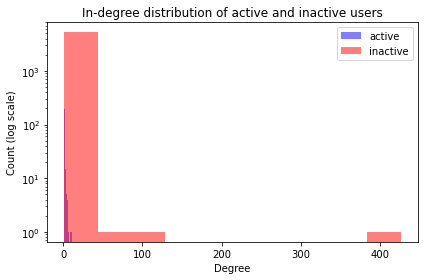

In [ ]:
%matplotlib inline

plt.hist([G.in_degree(x) for x in np.unique(G.nodes(), return_counts=True)[0] if user_map[x] == 1], color='b', alpha=0.5, label='active')

plt.hist([G.in_degree(x) for x in np.unique(G.nodes(), return_counts=True)[0] if user_map[x] == 0], color='r', alpha=0.5, label='inactive')

plt.yscale('log')
plt.xscale('log')
plt.title('In-degree distribution of active and inactive users')
plt.legend()
plt.xlabel('Degree (log scale)')
plt.ylabel('Count (log scale)')

plt.show()


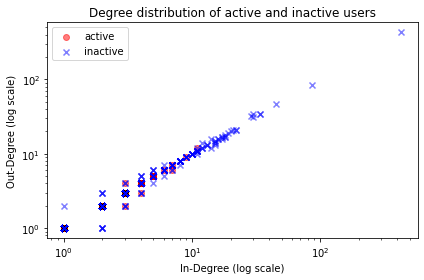

In [ ]:
%matplotlib inline
positive_nodes = [x for x in np.unique(G.nodes(), return_counts=True)[0] if user_map[x] == 1]
negative_nodes = [x for x in np.unique(G.nodes(), return_counts=True)[0] if user_map[x] == 0]

plt.scatter([G.in_degree(x) for x in positive_nodes], [G.out_degree(x) for x in positive_nodes], color='r', marker='o', alpha=0.5, label='active')

plt.scatter([G.in_degree(x) for x in negative_nodes], [G.out_degree(x) for x in negative_nodes], color='b', marker='x', alpha=0.5, label='inactive')

plt.yscale('log')
plt.xscale('log')
plt.title('Degree distribution of active and inactive users')
plt.legend()
plt.xlabel('In-Degree (log scale)')
plt.ylabel('Out-Degree (log scale)')

plt.show()


In [ ]:
'''
while True:  
    in_degs=[]
    out_degs=[]
    while len(in_degs)<100:
        nextval = int(nx.utils.powerlaw_sequence(1, 2.5)[0]) #100 nodes, power-law exponent 2.5
        #if nextval!=0:
        in_degs.append(nextval)
        nextval = int(nx.utils.powerlaw_sequence(1, 2.5)[0]) #100 nodes, power-law exponent 2.5
        #if nextval!=0:
        out_degs.append(nextval)
        
    if sum(in_degs)%2 == 0:
        break
G = nx.configuration_model(s)
G=nx.Graph(G) # remove parallel edges
G.remove_edges_from(G.selfloop_edges())
'''

'\nwhile True:  \n    in_degs=[]\n    out_degs=[]\n    while len(in_degs)<100:\n        nextval = int(nx.utils.powerlaw_sequence(1, 2.5)[0]) #100 nodes, power-law exponent 2.5\n        #if nextval!=0:\n        in_degs.append(nextval)\n        nextval = int(nx.utils.powerlaw_sequence(1, 2.5)[0]) #100 nodes, power-law exponent 2.5\n        #if nextval!=0:\n        out_degs.append(nextval)\n        \n    if sum(in_degs)%2 == 0:\n        break\nG = nx.configuration_model(s)\nG=nx.Graph(G) # remove parallel edges\nG.remove_edges_from(G.selfloop_edges())\n'

In [ ]:
in_degs = nx.create_degree_sequence(100, nx.utils.powerlaw_sequence, dict(n=100, exponent=3.0))
out_degs = nx.create_degree_sequence(100, nx.utils.powerlaw_sequence, dict(n=100, exponent=3.0))

G = nx.directed_configuration_model(in_degs, out_degs)
G=nx.DiGraph(G) # remove parallel edges
G.remove_edges_from(G.selfloop_edges())


AttributeError: module 'networkx' has no attribute 'create_degree_sequence'

In [ ]:
def gen_graph(num_nodes, exp):
    seq = [int(x) for x in nx.utils.powerlaw_sequence(num_nodes, exp)]
    G = nx.directed_configuration_model(seq, seq)
    G=nx.DiGraph(G)
    #G.remove_edges_from(G.selfloop_edges())
    return G

In [ ]:
G.number_of_nodes()

In [ ]:
np.mean(G.in_degree())

In [ ]:
%matplotlib inline

plt.hist([G.in_degree(x) for x in G.nodes()], color='b', alpha=0.5)

plt.show